In [1]:
import os

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, GlobalMaxPooling1D

import re
import pandas as pd
import numpy as np

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Prateek\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Train Data
df = pd.read_csv("train-1546603042473.csv", header=0)
df = df.replace(np.nan, 'emptyconversation', regex=True)
df.shape

(48699, 2)

In [57]:
# Test Data
test = pd.read_csv("test-1546603743049.csv")
test = test.replace(np.nan, 'emptyconversation', regex= True)
test = test.iloc[:, 1].values   # test feature matrix
test.shape 

(8581,)

In [4]:
df['converse'].isnull().sum()

0

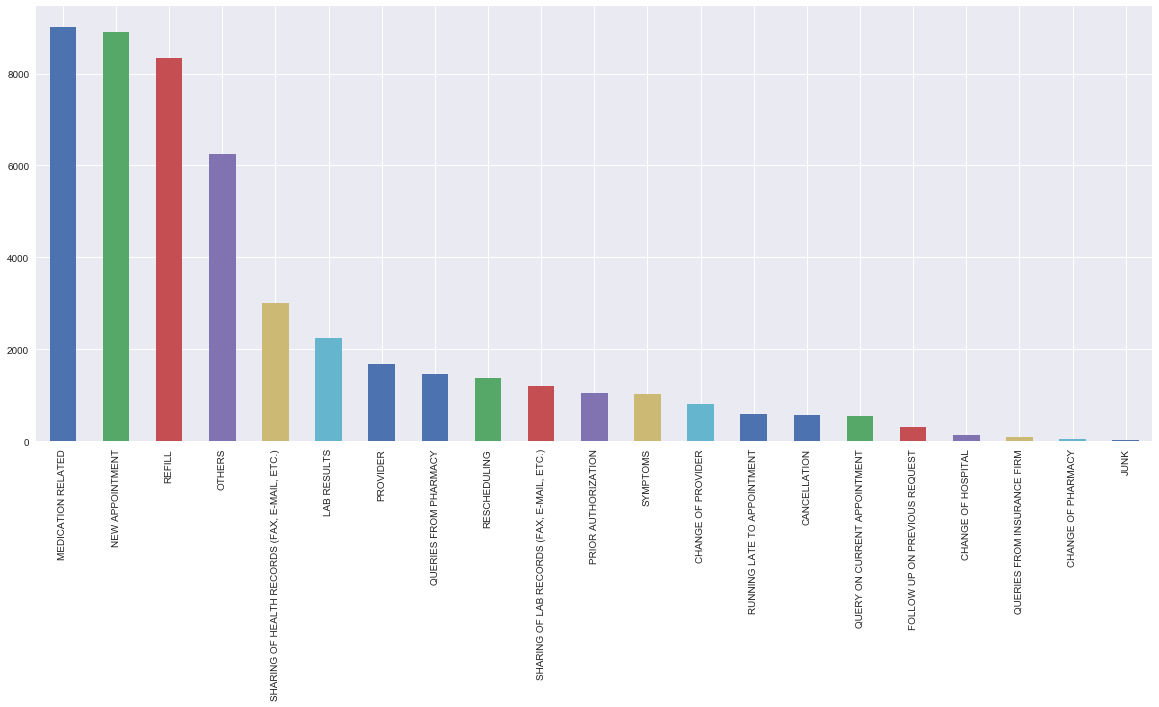

In [52]:
import matplotlib.pyplot as plt

my_categories = ['MEDICATION RELATED','NEW APPOINTMENT','REFILL ','OTHERS','SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)','LAB RESULTS','PROVIDER','QUERIES FROM PHARMACY','RESCHEDULING','SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)','PRIOR AUTHORIZATION','SYMPTOMS','CHANGE OF PROVIDER','RUNNING LATE TO APPOINTMENT','CANCELLATION','QUERY ON CURRENT APPOINTMENT','FOLLOW UP ON PREVIOUS REQUEST','CHANGE OF HOSPITAL','QUERIES FROM INSURANCE FIRM','CHANGE OF PHARMACY','JUNK ']
plt.figure(figsize=(20,8))
df.categories.value_counts().plot(kind='bar');

In [53]:
#Category distribution in train data
df.iloc[:,0].value_counts()

MEDICATION RELATED                               9010
NEW APPOINTMENT                                  8907
REFILL                                           8347
OTHERS                                           6253
SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)    3018
LAB RESULTS                                      2253
PROVIDER                                         1677
QUERIES FROM PHARMACY                            1464
RESCHEDULING                                     1383
SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)       1212
PRIOR AUTHORIZATION                              1043
SYMPTOMS                                         1021
CHANGE OF PROVIDER                                811
RUNNING LATE TO APPOINTMENT                       590
CANCELLATION                                      564
QUERY ON CURRENT APPOINTMENT                      559
FOLLOW UP ON PREVIOUS REQUEST                     304
CHANGE OF HOSPITAL                                127
QUERIES FROM INSURANCE FIRM 

In [54]:
# Find Categories for "emptyconversation"
pd.unique(df[(df.converse == 'emptyconversation')].categories)

array(['OTHERS', 'JUNK', 'CANCELLATION', 'RESCHEDULING'], dtype=object)

In [55]:
# Counting words Train
word_Count = df['converse'].apply(lambda x: len(str(x).split(" ")))
word_Count.max()

463

In [5]:
x = df.iloc[:, 1].values   # train feature matrix
y = df.iloc[:, 0].values   # train Target Classes

In [6]:
x.shape

(48699,)

In [7]:
# Prepare tokenizer
tokenizer = Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
# Training tokenizer on training text
tokenizer.fit_on_texts(x)

In [8]:
word_Index = tokenizer.word_index
vocab_Size = len(word_Index) + 1
print('Found %s unique tokens for Training Text(Features).' % vocab_Size)
# Generating integer encoding of words
sequences = tokenizer.texts_to_sequences(x)
print(x[1], sequences[1])

Found 35749 unique tokens for Training Text(Features).
lmovm for patients mother to and schd rov tracy dominguez am kellee currie pm rhonda fanning [661, 5, 2, 518, 1, 3, 574, 106, 695, 815, 27, 380, 418, 25, 387, 2461]


In [9]:
# Tokenizing TEST-DATA : text
tokenizer.fit_on_texts(test)

word_Index = tokenizer.word_index
vocab_Size = len(word_Index) + 1
print('Found %s unique tokens. after Testing Text tokenization' % vocab_Size)

Found 39290 unique tokens. after Testing Text tokenization


### Final Vocab  Size including both test and train 'text' = 39290

In [12]:
# Padding TEST DATA text:
MAX_SEQUENCE_LENGTH = 700
sequences_test = tokenizer.texts_to_sequences(test)
padded_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
padded_test.shape

(8581, 700)

In [13]:
# Padding TRAIN DATA text:
padded_x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of padded_sequence tensor:', padded_x.shape)

Shape of padded_sequence tensor: (48699, 700)


In [14]:
 # Label Encoding categorical data for the classification category
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_Y = LabelEncoder()
y = labelencoder_Y.fit_transform(y)
print(y)
print(np.unique(y, return_counts=True))

[13  8  9 ... 15  8  7]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64), array([ 564,  127,   47,  811,  304,   18, 2253, 9010, 8907, 6253, 1043,
       1677,   91, 1464,  559, 8347, 1383,  590, 3018, 1212, 1021],
      dtype=int64))


In [15]:
# Perform one hot encoding 
y = to_categorical(y, num_classes= 21)
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_x, y, test_size = 0.2, random_state = 21, stratify=y)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(38959, 700)
(38959, 21)
(9740, 700)
(9740, 21)


In [18]:
X_train

array([[    0,     0,     0, ..., 10578,  9436,   491],
       [    0,     0,     0, ...,   867,  1284,    14],
       [    0,     0,     0, ...,   189,    95,   197],
       ...,
       [    0,     0,     0, ...,   498,     9,    27],
       [    0,     0,     0, ...,    35,   143,   203],
       [    0,     0,     0, ...,   336,   567,    14]])

In [19]:
# Preparing the Embedding layer
embeddings_index = {}
f = open(file="glove.6B.100d.txt", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_Matrix = np.zeros((vocab_Size, 100))
for word, i in word_Index.items():
    embedding_Vector = embeddings_index.get(word)
    if embedding_Vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_Matrix[i] = embedding_Vector

print (embedding_Matrix.shape)

Found 400000 word vectors.
(39290, 100)


## Model LSTM

In [20]:
from keras.layers import LSTM

model=Sequential()

model.add(Embedding(vocab_Size,100,weights=[embedding_Matrix],input_length=700,trainable=True))

model.add(LSTM(64,dropout=0.4, recurrent_dropout=0.2))

# number of parameters learnt = 4 * (m *n + n*n + n) : the last n is for bias!
# m= number of inputs passed to lstm = 100
# n= 64 = number of neurons chosen


model.add(Dense(21, activation='softmax'))
# number of paramertrs learnt in dense layer = 64*21 + bias=21

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 100)          3929000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 21)                1365      
Total params: 3,972,605
Trainable params: 3,972,605
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Train X_train, X_test, y_train, y_test
model.fit(X_train, y_train, epochs=7, verbose=1, validation_data=(X_test, y_test), batch_size=40, class_weight='balanced')

Train on 38959 samples, validate on 9740 samples
Epoch 1/7
38959/38959 [==============================] - 950s 24ms/step - loss: 1.7175 - acc: 0.4746 - val_loss: 1.2495 - val_acc: 0.6143
Epoch 2/7
38959/38959 [==============================] - 751s 19ms/step - loss: 1.1123 - acc: 0.6537 - val_loss: 0.9399 - val_acc: 0.6976
Epoch 3/7
38959/38959 [==============================] - 748s 19ms/step - loss: 0.9060 - acc: 0.7126 - val_loss: 0.8535 - val_acc: 0.7158
Epoch 4/7
38959/38959 [==============================] - 764s 20ms/step - loss: 0.8213 - acc: 0.7332 - val_loss: 0.8146 - val_acc: 0.7278
Epoch 5/7
38959/38959 [==============================] - 758s 19ms/step - loss: 0.7576 - acc: 0.7521 - val_loss: 0.7934 - val_acc: 0.7318
Epoch 6/7
38959/38959 [==============================] - 752s 19ms/step - loss: 0.7026 - acc: 0.7684 - val_loss: 0.7789 - val_acc: 0.7433
Epoch 7/7
38959/38959 [==============================] - 753s 19ms/step - loss: 0.6511 - acc: 0.7856 - val_loss: 0.7829 - v

In [51]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 100)          3929000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 21)                1365      
Total params: 3,972,605
Trainable params: 3,972,605
Non-trainable params: 0
_________________________________________________________________


### Making Prediction and creating Submission file

In [24]:
prediction=model.predict_classes(padded_test)

In [44]:
prediction.shape

(8581,)

In [26]:
out1=labelencoder_Y.inverse_transform(prediction)
out1

C:\Users\Prateek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['NEW APPOINTMENT', 'NEW APPOINTMENT', 'MEDICATION RELATED', ...,
       'MEDICATION RELATED', 'PROVIDER', 'NEW APPOINTMENT'], dtype=object)

In [27]:
outdf1 = pd.DataFrame(out1)
outdf1.to_csv("outtest1.csv")

In [28]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

Accuracy: 74.209446


In [29]:
print('Accuracy on Validation Data: %f' % (accuracy*100))

Accuracy on Validation Data: 74.209446


### Some Visualization

In [41]:
test1 = pd.read_csv("train-1546603042473.csv")
test1

,categories,converse
0,QUERIES FROM PHARMACY,please to verify instructions for drugname pat...
1,NEW APPOINTMENT,lmovm for patients mother to and schd rov trac...
2,OTHERS,labtype and insurance approval other incoming ...
3,OTHERS,clinical list changes medfusion secure electro...
4,MEDICATION RELATED,wants to wean off medication work phone name d...
5,MEDICATION RELATED,patient declining following up name patient ap...
6,MEDICATION RELATED,patients clld to speak with the rn about injec...
7,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",need signature athena lab form patient appoint...
8,MEDICATION RELATED,increase in has and neck pain given to patient...
9,REFILL,Rx refill drugname xr name grandparent for pre...


In [42]:

score = model.evaluate(X_test, y_test,
                       batch_size=32, verbose=1)
 
print('Test accuracy:', score[1])
 
text_labels = labelencoder_Y.classes_
 
for i in range(10):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    
    print('Actual label:' + test1.categories.iloc[i])
    print("Predicted label: " + predicted_label)

9740/9740 [==============================] - 143s 15ms/step
Test accuracy: 0.7420944558276777
Actual label:QUERIES FROM PHARMACY
Predicted label: OTHERS
Actual label:NEW APPOINTMENT
Predicted label: REFILL
Actual label:OTHERS
Predicted label: OTHERS
Actual label:OTHERS
Predicted label: OTHERS
Actual label:MEDICATION RELATED
Predicted label: RESCHEDULING
Actual label:MEDICATION RELATED
Predicted label: MEDICATION RELATED
Actual label:MEDICATION RELATED
Predicted label: SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
Actual label:SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
Predicted label: RESCHEDULING
Actual label:MEDICATION RELATED
Predicted label: PRIOR AUTHORIZATION
Actual label:REFILL
Predicted label: MEDICATION RELATED


In [45]:
prediction

array([[5.1431119e-04, 7.1910708e-03, 8.1269874e-04, 1.1078848e-02,
        2.1133069e-02, 6.1416135e-06, 2.9844160e-03, 6.5732151e-01,
        1.2914154e-02, 2.6719382e-02, 2.0320919e-01, 6.5970034e-03,
        2.0548084e-03, 1.5150305e-03, 2.3488547e-03, 3.6071528e-02,
        1.1745153e-04, 4.7817573e-04, 2.7609048e-03, 3.2917643e-04,
        3.8422297e-03]], dtype=float32)

In [1]:
#from sklearn.metrics import confusion_matrix
#conf_mat = confusion_matrix(y_test, out2)
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(conf_mat, annot=True, fmt='d',
#            xticklabels=test1.categories.values, yticklabels=test1.categories.values)
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#plt.show()
# Cannot handle multilevel target

In [48]:
prediction1=model.predict_classes(X_test)

## LSTM Model

In [61]:
from keras.layers import Bidirectional
from keras.layers import Dropout, BatchNormalization, core
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import LSTM

model3 = Sequential()
model3.add(Embedding(vocab_Size, 
                    100, 
                    weights=[embedding_Matrix], 
                    input_length=700, 
                    trainable=True))
model3.add(LSTM(64,dropout=0.4, recurrent_dropout=0.3))

model3.add(Dense(21, activation='softmax'))


model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 700, 100)          3929000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 21)                1365      
Total params: 3,972,605
Trainable params: 3,972,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training
model3.fit(x_train, y_train,
           epochs=9,
           verbose=1,
           validation_data=(x_val, y_val),
           batch_size=64)
    
loss, accuracy = model3_history.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3_history.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
sess = tf.Session(config=config)

In [ ]:
# Bi Directional LSTM

In [62]:
from keras.layers import Bidirectional
from keras.layers import Dropout, BatchNormalization, core
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import LSTM

model3b = Sequential()
model3b.add(Embedding(vocab_Size,
                     100,
                     weights=[embedding_Matrix],
                     input_length=700,
                     trainable=True))
model3b.add(Bidirectional(LSTM(50,dropout=0.4,recurrent_dropout=0.4)))
#model3.add(Dense(32, activation='relu'))
model3b.add(Dense(21, activation='softmax'))
model3b.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 700, 100)          3929000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_5 (Dense)              (None, 21)                2121      
Total params: 3,991,521
Trainable params: 3,991,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
 model3b.fit(x_train, y_train,
             epochs=9,
             verbose=1,
             validation_data=(x_val, y_val),
             batch_size=32)
    
loss, accuracy = model3b_history.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3b_history.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
sess = tf.Session(config=config)

In [ ]:
prediction=model3b.predict_classes(padded_test)

In [ ]:
out=labelencoder_Y.inverse_transform(prediction)

In [ ]:
outdf = pd.DataFrame(out)
outdf.to_csv("outdf5.csv")